# Geoprocessing in Python #

The Federal State of Nordrhein-Westfalen (NRW, North Rhine-Westphalia) provides Digital Terrain Models (DTM) gained from Airborne Laser Scanning (ALS). One of the derived remote sensing products is an interpolated DTM on a regular grid with 1m² horizontal (x-y-plane) grid size (1m x 1m). 

The DTM data is dissected in regular square tiles with 2000 x 2000 grid cells each corresponding to 2000 m x 2000 m metric area. These tiles are organized according to the municipalities in NRW. All tiles touching a municipality are pooled in archive and compressed (zipped).

But the chosen file format to store the tiles is strange. The original file format of each tile is a formatted text file with three columns for the x-y-z coordinates denoted as XYZ file format. Each row in the text file represents one grid point in space. Each cell is represented by its full x-y-coordinates in the chosen coordinate reference system (EPSG:4647) together with the interesting information: the elevation z. 

Since each tile is a square grid with 2000 x 2000 cells it is regular and it would be enough e.g. to store the lower left corner coordinates together with the organisation of the grid cells (e.g. 2000 rows, 2000 columns, rows stored firstly) and then the pure z-coordinates sequentially. The x-y-coordinates of each grid cell could be determined by counting the z-values in the file: z-value at position 0 is at lower left corner, z-value at position 3'999'999 is at upper right corner, z-value at 1999 is at lower right corner (depending on whether data is stored row-wise or column-wise). 

Sometimes the upper right corner is the reference point. It just has to be described how data is organized.

geoTiff is a file format suited for handling regular geo-referenced grids.

The following activity deals with the transfromation from xyz-format to geoTiff.

But first the the bounding boxes of the available DTM tiles have to be determined to see which area they cover and whether they lie in the actual region of interest. 




### Prerequisites

* Install the Anaconda3 Python distribution.
* Open the Anaconda Prompt (bash-like terminal) and install the package gdal: `conda install gdal`

In [13]:
import os, sys
from osgeo import osr, ogr, gdal
from pathlib import Path as pt

In [14]:
import osgeo
help(osgeo)

Help on package osgeo:

NAME
    osgeo - # __init__ for osgeo package.

PACKAGE CONTENTS
    _gdal
    _gdal_array
    _gdalconst
    _gnm
    _ogr
    _osr
    gdal
    gdal_array
    gdalconst
    gdalnumeric
    gnm
    ogr
    osr

DATA
    version_info = sys.version_info(major=3, minor=7, micro=3, releaseleve...

VERSION
    3.0.2

FILE
    /Users/kultiginbozdemir/anaconda3/envs/QGIS/lib/python3.7/site-packages/osgeo/__init__.py




### Relative Path to Directory with the DTM XYZ-Files

In [15]:
# get the current working directory
os.getcwd()

'/Users/kultiginbozdemir/Documents/GitHub/geoinformatics2019/MIE_2.02_GeoInfo_WS2019/gi0301_ALS_DTM_NRW'

In [18]:
#where the xyz files are
dtm_xyz_dir = "/Users/kultiginbozdemir/Documents/GitHub/geoinformatics2019/MIE_2.02_GeoInfo_WS2019/data/DTM_Xanten/dgm1_05170052_Xanten_EPSG4647_XYZ/"
dest_dir = "/Users/kultiginbozdemir/Documents/GitHub/geoinformatics2019/MIE_2.02_GeoInfo_WS2019/data/derived/DTM_Xanten/"
dest_shapefile_name = "dgm1_Xanten_BB_coverage.shp" # shape file with bounding boxes, DGM: Digitales Geländemodell (de) <-> Digital Terrain Model (en)

dest_geotiff_dir = "/Users/kultiginbozdemir/Documents/GitHub/geoinformatics2019/MIE_2.02_GeoInfo_WS2019/data/derived/DTM_Xanten/geoTiff/" ## directory of geoTiff files 

os.makedirs(dest_dir, exist_ok = True)
os.makedirs(dest_geotiff_dir, exist_ok = True)

In [19]:
os.listdir(dtm_xyz_dir)

['.dgm1_32322_5726_2_nw.xyz.icloud',
 '.dgm1_32326_5720_2_nw.xyz.icloud',
 '.dgm1_32322_5730_2_nw.xyz.icloud',
 '.dgm1_32320_5734_2_nw.xyz.icloud',
 '.dgm1_32318_5734_2_nw.xyz.icloud',
 '.dgm1_32324_5724_2_nw.xyz.icloud',
 '.dgm1_32320_5722_2_nw.xyz.icloud',
 '.dgm1_32326_5726_2_nw.xyz.icloud',
 '.dgm1_32318_5724_2_nw.xyz.icloud',
 '.dgm1_32324_5722_2_nw.xyz.icloud',
 '.dgm1_32320_5724_2_nw.xyz.icloud',
 '.dgm1_32320_5732_2_nw.xyz.icloud',
 '.dgm1_32318_5732_2_nw.xyz.icloud',
 '.dgm1_32322_5728_2_nw.xyz.icloud',
 '.dgm1_32322_5734_2_nw.xyz.icloud',
 '.dgm1_32328_5722_2_nw.xyz.icloud',
 '.dgm1_32324_5728_2_nw.xyz.icloud',
 '.dgm1_32322_5722_2_nw.xyz.icloud',
 '.dgm1_32326_5724_2_nw.xyz.icloud',
 '.dgm1_32318_5726_2_nw.xyz.icloud',
 '.dgm1_32324_5720_2_nw.xyz.icloud',
 '.dgm1_32320_5726_2_nw.xyz.icloud',
 '.dgm1_32320_5730_2_nw.xyz.icloud',
 '.dgm1_32318_5730_2_nw.xyz.icloud',
 '.dgm1_32322_5724_2_nw.xyz.icloud',
 '.dgm1_32326_5722_2_nw.xyz.icloud',
 '.dgm1_32320_5728_2_nw.xyz.icloud',
 

### Create a list with all xyz-file names

In [25]:
fnamelist = []
for fname in os.listdir(dtm_xyz_dir):
    if fname.endswith(".xyz"):
        fnamelist.append(fname)

fnamelist

['dgm1_32320_5724_2_nw.xyz',
 'dgm1_32326_5720_2_nw.xyz',
 'dgm1_32324_5724_2_nw.xyz',
 'dgm1_32316_5730_2_nw.xyz',
 'dgm1_32320_5732_2_nw.xyz',
 'dgm1_32318_5726_2_nw.xyz',
 'dgm1_32320_5734_2_nw.xyz',
 'dgm1_32322_5730_2_nw.xyz',
 'dgm1_32324_5730_2_nw.xyz',
 'dgm1_32322_5722_2_nw.xyz']

### Define a function which evaluates first and last row to get the bounding box

In [101]:
def getBB (fname, pixelsize):
    with open(fname, 'rb') as fh:
        first = next(fh)
        offs = -100
        while True:
            fh.seek(offs, 2)
            lines = fh.readlines()
            if len(lines)>1:
                last = lines[-1]
                break
            offs *= 2
        print("first: ", first)
        print ("last: ", last)

        [left, bottom, z_ws] = list(map(float, first.split()))
        [right, top, z_en] = list(map(float, last.split()))
        left, right, bottom, top = left - pixelsize/2., right + pixelsize/2., bottom - pixelsize/2., top + pixelsize/2.

        return [left, right, bottom, top] 

### Create a shape file the rectangular bounding boxes of the xyz files

In [102]:
# get the driver
driver = ogr.GetDriverByName('ESRI Shapefile')
# create a new data source and layer

#pathname = myDestDataDir + r'/dgm1_Xanten_BB_coverage.shp'

pathfilename = dest_dir + dest_shapefile_name

print("Output File: ", pathfilename)

if os.path.exists(pathfilename):
    driver.DeleteDataSource(pathfilename)

ds = driver.CreateDataSource(pathfilename)

if ds is None:
    print('Could not create file')
    sys.exit(1)


#~ src_srs = txt2srs('EPSG:4647')
#src_srs= txt2srs('+proj=tmerc +lat_0=0 +lon_0=9 +k=0.9996 +x_0=32500000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs')    

epsg = 4647
srs1 = osr.SpatialReference()
srs1.ImportFromEPSG(epsg)

#layer_name = 'test'
#layer_name = layer_name.encode('utf-8')
#layer = ds.CreateLayer(layer_name, srs, ogr.wkbPolygon)

layer = ds.CreateLayer('test', geom_type=ogr.wkbPolygon, srs=srs1)
#layer = ds.CreateLayer('test', geom_type=ogr.wkbPolygon)

fieldDefnID = ogr.FieldDefn('id', ogr.OFTInteger)
fieldDefnFName = ogr.FieldDefn('fname', ogr.OFTString)

res = layer.CreateField(fieldDefnID)
res =layer.CreateField(fieldDefnFName)


# get the FeatureDefn for the output layer
featureDefn = layer.GetLayerDefn()

# ID
i=0

pixelsize = 1

for fname in fnamelist:
    [x0, x1, y0, y1] = getBB(dtm_xyz_dir+fname, pixelsize)
    #print(x0, x1, y0, y1)
    ring = ogr.Geometry(ogr.wkbLinearRing)
    ring.AddPoint(x0,y0)
    ring.AddPoint(x1,y0)
    ring.AddPoint(x1,y1)
    ring.AddPoint(x0,y1)
    ring.AddPoint(x0,y0)
    #ring.CloseRings() # or ring.AddPoint(0,0)
    
    polygon = ogr.Geometry(ogr.wkbPolygon)
    polygon.AddGeometry(ring)
    
    feature = ogr.Feature(featureDefn)
    feature.SetGeometry(polygon)

    i+=1
    feature.SetField('id', i)
    feature.SetField('fname', fname)
    # add the feature to the output layer
    layer.CreateFeature(feature)
    
    #ring.Destroy()
    #polygon.Destroy()
    #feature.Destroy()

ds.Destroy()


Output File:  /Users/kultiginbozdemir/Documents/GitHub/geoinformatics2019/QGIS_projects/MIE_2.02_GeoInfo_WS2019/data/derived/DTM_Xanten/dgm1_Xanten_BB_coverage.shp
first:  b'32320000.00 5724000.00   21.56\n'
last:  b'32321999.00 5725999.00   21.77\n'
first:  b'32326000.00 5720000.00   24.73\n'
last:  b'32327999.00 5721999.00   17.96\n'
first:  b'32324000.00 5724000.00   41.36\n'
last:  b'32325999.00 5725999.00   16.66\n'
first:  b'32316000.00 5730000.00   21.44\n'
last:  b'32317999.00 5731999.00   16.98\n'
first:  b'32320000.00 5732000.00   19.71\n'
last:  b'32321999.00 5733999.00   15.66\n'
first:  b'32318000.00 5726000.00   29.25\n'
last:  b'32319999.00 5727999.00   20.53\n'
first:  b'32320000.00 5734000.00   17.10\n'
last:  b'32321999.00 5735999.00   13.96\n'
first:  b'32322000.00 5730000.00   14.83\n'
last:  b'32323999.00 5731999.00   13.80\n'
first:  b'32320000.00 5728000.00   20.34\n'
last:  b'32321999.00 5729999.00   14.85\n'
first:  b'32318000.00 5730000.00   37.85\n'
last:  b'

### Add the four filenames touching the GPS path in Hees and on Fürstenberg to the list.

In [103]:
# The files the GPS track is intersecting with
#hees_dtm_list=["dgm1_32322_5724_2_nw.xyz", "dgm1_32322_5722_2_nw.xyz","dgm1_32324_5722_2_nw.xyz", "dgm1_32324_5724_2_nw.xyz"]

In [104]:
import pandas as pd

In [26]:
selected=pd.read_csv(dest_dir+'selected4.csv')
hees_dtm_list=list(selected.fname)
print(hees_dtm_list)

['dgm1_32324_5724_2_nw.xyz', 'dgm1_32324_5722_2_nw.xyz', 'dgm1_32322_5722_2_nw.xyz', 'dgm1_32322_5724_2_nw.xyz']


The following example is derived from here:  
https://gis.stackexchange.com/questions/58517/python-gdal-save-array-as-raster-with-projection-from-other-fil  
and here:
https://gis.stackexchange.com/questions/177061/ascii-file-with-latitude-longitude-and-data-to-geotiff-using-python


In [27]:
def CreateGeoTiff(Name, Array, driver, 
                  xnum, ynum, GeoT):
    DataType = gdal.GDT_Float32
    NewFileName = Name+'.tif'
    
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4647)
    # Set up the dataset
    DataSet = driver.Create( NewFileName, xnum, ynum, 1, DataType )
            # the '1' is for band 1.
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(srs.ExportToWkt())

    # Write the array
    DataSet.GetRasterBand(1).WriteArray( Array )
    return NewFileName

In [28]:

for source in hees_dtm_list:
    base=os.path.basename(source)
    name = os.path.splitext(base)[0]
    print(name)

dgm1_32324_5724_2_nw
dgm1_32324_5722_2_nw
dgm1_32322_5722_2_nw
dgm1_32322_5724_2_nw


In [29]:
hees_dtm_list

['dgm1_32324_5724_2_nw.xyz',
 'dgm1_32324_5722_2_nw.xyz',
 'dgm1_32322_5722_2_nw.xyz',
 'dgm1_32322_5724_2_nw.xyz']

In [30]:
import pandas as pd
from os.path import basename
import numpy as np

xnum, ynum = 2000, 2000
xsize, ysize = 1,1
driver = gdal.GetDriverByName('GTiff')


for source in hees_dtm_list:
    print("read " + source)
    df=pd.read_csv(dtm_xyz_dir + source,header=None,delim_whitespace=True,names=["x","y","z"])
    xmin, xmax = min(df.x), max(df.x)
    ymin, ymax = min(df.y), max(df.y)
    zmin, zmax = min(df.z), max(df.z)
    GeoTNew=[xmin, xsize, 0, ymax, 0, -ysize] # WHY IS IT LIKE THIS ?????? WHAT DOES IT DO ?????
    #print(GeoTNew)
    z=(df.z).values.reshape(ynum,xnum)
    #print((df.z).values, ynum, xnum)
    #print(z)
    z=np.rot90(z) # If we do not rotate the 2000x2000 pixel array the final result is rotated!
   
    base=os.path.basename(source)
    name = os.path.splitext(base)[0]
    
    print("write " + name + ".tif")    
    NewFileName = CreateGeoTiff(dest_geotiff_dir + name, z, driver, xnum, ynum, GeoTNew)
    

read dgm1_32324_5724_2_nw.xyz
write dgm1_32324_5724_2_nw.tif
read dgm1_32324_5722_2_nw.xyz


FileNotFoundError: [Errno 2] File b'/Users/kultiginbozdemir/Documents/GitHub/geoinformatics2019/MIE_2.02_GeoInfo_WS2019/data/DTM_Xanten/dgm1_05170052_Xanten_EPSG4647_XYZ/dgm1_32324_5722_2_nw.xyz' does not exist: b'/Users/kultiginbozdemir/Documents/GitHub/geoinformatics2019/MIE_2.02_GeoInfo_WS2019/data/DTM_Xanten/dgm1_05170052_Xanten_EPSG4647_XYZ/dgm1_32324_5722_2_nw.xyz'

In [110]:
#Read the selected 4 boxes. Since my QGIS is not merging, I am doing it here.
#then import them in QGIS. Since they are too large, I created a small set later on, it is named verySouth.
cdf=pd.DataFrame(columns=["x","y","z"])
for source in hees_dtm_list:
    print("read " + source)
    cdf=cdf.append(pd.read_csv(dtm_xyz_dir + source,header=None,delim_whitespace=True,names=["x","y","z"]))
    
#pd.concat(cdf,df)
print(len(cdf))

read dgm1_32324_5724_2_nw.xyz
read dgm1_32324_5722_2_nw.xyz
read dgm1_32322_5722_2_nw.xyz
read dgm1_32322_5724_2_nw.xyz
16000000


In [111]:
print(cdf.head(5))
cdf.to_csv (dest_dir+'combinedxyz.csv', ',') 

            x          y      z
0  32324000.0  5724000.0  41.36
1  32324000.0  5724001.0  41.34
2  32324000.0  5724002.0  41.32
3  32324000.0  5724003.0  41.30
4  32324000.0  5724004.0  41.27


In [31]:
gdf=pd.read_csv(dest_dir+'20171111.csv',header=None, delimiter=',', 
                  names=(None))

#print(gdf)
gdf=gdf.drop(columns=([0,4,5,6,7,8,9,10,11,12,13,14,15,16,17]))
gdf.columns=["lat","lon","alt"]
gdf=gdf.drop([0])
print(gdf.head(5))
gdf=gdf.astype(float)



         lat       lon   alt
1  51.654742  6.448487   0.0
2  51.654879  6.448360  82.0
3  51.654941  6.448322  96.0
4  51.654909  6.448327  95.0
5  51.654901  6.448351  91.0


In [32]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [33]:
geo = gpd.GeoDataFrame(
    gdf.drop(['lat', 'lon','alt'], axis=1),
    crs={'init': 'epsg:4326'},
    geometry=[Point(xyz) for xyz in zip(gdf.lon, gdf.lat, gdf.alt)])
print(geo)
geo.to_file(dest_dir+'GPS.shp')

                                 geometry
1      POINT Z (6.44849 51.65474 0.00000)
2     POINT Z (6.44836 51.65488 82.00000)
3     POINT Z (6.44832 51.65494 96.00000)
4     POINT Z (6.44833 51.65491 95.00000)
5     POINT Z (6.44835 51.65490 91.00000)
...                                   ...
2865   POINT Z (6.44845 51.65478 0.00000)
2866  POINT Z (6.44834 51.65485 72.00000)
2867  POINT Z (6.44834 51.65485 71.00000)
2868  POINT Z (6.44834 51.65484 71.00000)
2869  POINT Z (6.44834 51.65483 70.00000)

[2869 rows x 1 columns]


In [77]:

fp = dest_dir+'GPS.shp'
GPSdata = gpd.read_file(fp, names=('x','y','z'))
print(GPSdata.head(7))
print(GPSdata.crs)
GPSdata= GPSdata.to_crs(epsg=4647)
print(GPSdata.crs)
#print(GPSdata['geometry'].has_z)
GPS=list()
for i in range(len(GPSdata['geometry'])):
    x=GPSdata['geometry'][i].x
    y=GPSdata['geometry'][i].y
    z=GPSdata['geometry'][i].z
    GPS.append([int(x),int(y),z])
GPS=pd.DataFrame(GPS,columns=['gx','gy','gz'])
print("After cutting the floating part:\n",GPS.head(7))

   FID                             geometry
0    0   POINT Z (6.44849 51.65474 0.00000)
1    1  POINT Z (6.44836 51.65488 82.00000)
2    2  POINT Z (6.44832 51.65494 96.00000)
3    3  POINT Z (6.44833 51.65491 95.00000)
4    4  POINT Z (6.44835 51.65490 91.00000)
5    5  POINT Z (6.44836 51.65489 86.00000)
6    6  POINT Z (6.44837 51.65490 85.00000)
{'init': 'epsg:4326'}
{'init': 'epsg:4647', 'no_defs': True}
After cutting the floating part:
          gx       gy    gz
0  32323506  5725721   0.0
1  32323498  5725737  82.0
2  32323495  5725744  96.0
3  32323495  5725740  95.0
4  32323497  5725739  91.0
5  32323498  5725738  86.0
6  32323498  5725739  85.0


In [78]:
print(GPS)
GPS.to_csv ((dest_dir+'GPScutoff.csv'), ',') 

            gx       gy    gz
0     32323506  5725721   0.0
1     32323498  5725737  82.0
2     32323495  5725744  96.0
3     32323495  5725740  95.0
4     32323497  5725739  91.0
...        ...      ...   ...
2864  32323503  5725725   0.0
2865  32323496  5725734  72.0
2866  32323496  5725733  71.0
2867  32323496  5725732  71.0
2868  32323496  5725732  70.0

[2869 rows x 3 columns]


In [49]:
#create an empty df for selected data set. 
south=list()


#read shape file.
fp = dest_dir+'verySouth.shp'
XYZdata = gpd.read_file(fp)

print(XYZdata.geometry[0])
for i in range(len(XYZdata['geometry'])):
    x=XYZdata['geometry'][i].x
    y=XYZdata['geometry'][i].y
    z=XYZdata['geometry'][i].z
    south.append([x,y,z])

POINT Z (32323308 5723036 21.94)


In [53]:
south=pd.DataFrame(south, columns=['fx','fy','fz'])
print(south.head())

           fx         fy     fz
0  32323308.0  5723036.0  21.94
1  32323308.0  5723037.0  21.95
2  32323308.0  5723038.0  21.87
3  32323308.0  5723039.0  21.84
4  32323308.0  5723040.0  21.79


In [110]:

for row in GPS.itertuples():
    print(row[3])

0.0
82.0
96.0
95.0
91.0
86.0
85.0
81.0
85.0
84.0
79.0
74.0
73.0
70.0
70.0
69.0
70.0
70.0
70.0
70.0
71.0
73.0
71.0
71.0
72.0
72.0
69.0
68.0
68.0
67.0
66.0
67.0
66.0
65.0
0.0
63.0
64.0
64.0
62.0
61.0
61.0
64.0
64.0
64.0
65.0
66.0
69.0
69.0
69.0
69.0
69.0
68.0
67.0
67.0
65.0
65.0
0.0
66.0
67.0
68.0
66.0
66.0
67.0
0.0
67.0
68.0
67.0
68.0
63.0
62.0
64.0
62.0
59.0
58.0
56.0
56.0
56.0
57.0
57.0
59.0
58.0
58.0
57.0
56.0
57.0
57.0
60.0
63.0
65.0
65.0
65.0
66.0
67.0
66.0
67.0
68.0
68.0
67.0
65.0
0.0
64.0
65.0
67.0
65.0
69.0
70.0
68.0
68.0
69.0
66.0
65.0
64.0
65.0
64.0
64.0
63.0
63.0
63.0
63.0
62.0
59.0
59.0
56.0
55.0
56.0
58.0
57.0
57.0
56.0
56.0
56.0
55.0
57.0
57.0
63.0
61.0
62.0
63.0
65.0
61.0
0.0
59.0
59.0
62.0
63.0
62.0
64.0
61.0
60.0
60.0
62.0
62.0
63.0
62.0
62.0
63.0
63.0
63.0
66.0
66.0
67.0
68.0
68.0
68.0
68.0
69.0
70.0
72.0
0.0
73.0
70.0
71.0
71.0
72.0
71.0
0.0
67.0
68.0
70.0
70.0
70.0
68.0
0.0
63.0
63.0
60.0
58.0
61.0
61.0
0.0
61.0
63.0
64.0
64.0
66.0
67.0
0.0
66.0
66.0
66.0
65.0
63.0
6

80.0
79.0
79.0
78.0
79.0
80.0
79.0
79.0
74.0
77.0
81.0
83.0
84.0
84.0
84.0
84.0
84.0
84.0
85.0
85.0
86.0
86.0
83.0
83.0
81.0
82.0
82.0
83.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
83.0
83.0
85.0
83.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
81.0
81.0
82.0
82.0
82.0
82.0
83.0
83.0
83.0
78.0
78.0
80.0
81.0
80.0
80.0
81.0
80.0
80.0
79.0
82.0
81.0
80.0
78.0
76.0
72.0
74.0
75.0
76.0
80.0
80.0
79.0
79.0
78.0
78.0
79.0
80.0
85.0
86.0
88.0
88.0
91.0
90.0
91.0
91.0
91.0
90.0
90.0
91.0
89.0
90.0
90.0
89.0
89.0
90.0
91.0
91.0
90.0
88.0
85.0
86.0
86.0
84.0
82.0
78.0
78.0
76.0
77.0
77.0
75.0
75.0
77.0
77.0
79.0
79.0
80.0
80.0
82.0
83.0
83.0
83.0
82.0
81.0
82.0
80.0
78.0
78.0
77.0
78.0
78.0
78.0
78.0
78.0
78.0
77.0
77.0
78.0
78.0
78.0
78.0
78.0
78.0
78.0
75.0
77.0
78.0
78.0
78.0
78.0
78.0
78.0
78.0
78.0
77.0
76.0
76.0
77.0
81.0
81.0
79.0
80.0
81.0
81.0
81.0
81.0
81.0
81.0
81.0
81.0
81.0
81.0


In [114]:
alt=list()
for t in GPS.itertuples():
    for u in south.itertuples():
        if t[1]==u[1] and t[2]==u[2]:
            alt.append((t[0],t[1],t[2],t[3],u[3]))

In [118]:
combined=pd.DataFrame(alt)
combined.columns=["index",'gx','gy','gz','fz']
print(combined.head())

   index        gx       gy    gz     fz
0    631  32323313  5723394  78.0  49.32
1    632  32323317  5723392  76.0  49.52
2    633  32323321  5723390  72.0  49.41
3    634  32323326  5723390  70.0  49.26
4    635  32323333  5723390  68.0  48.98


In [9]:
import pandas as pd
df=pd.read_csv((dest_dir+'intersectGpsXyz.csv'),header=None,delimiter=',',
               names=('fx','fy','fz','gx','gy','gz'))

df=df.drop([0])
print(df)


FileNotFoundError: [Errno 2] File b'/Users/kultiginbozdemir/Documents/GitHub/geoinformatics2019/QGIS_projects/MIE_2.02_GeoInfo_WS2019/data/derived/DTM_Xanten/intersectGpsXyz.csv' does not exist: b'/Users/kultiginbozdemir/Documents/GitHub/geoinformatics2019/QGIS_projects/MIE_2.02_GeoInfo_WS2019/data/derived/DTM_Xanten/intersectGpsXyz.csv'

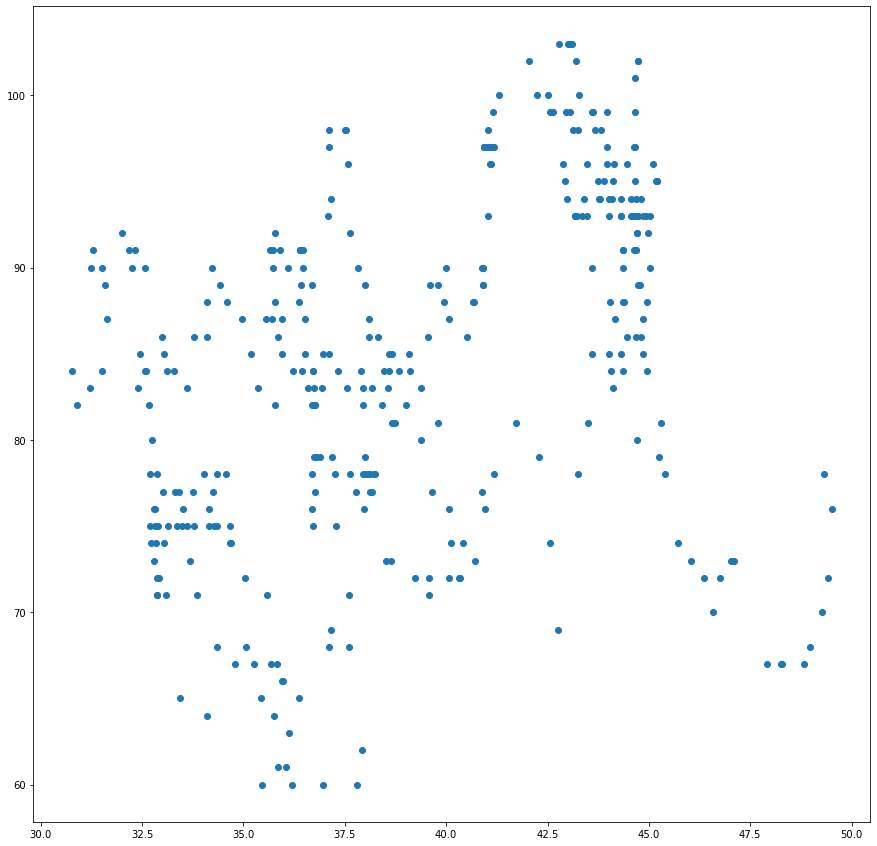

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

plt.scatter(combined.fz, combined.gz)
plt.show()




                     gz                  fz
1    90.000000000000000  45.039999999999999
2    78.000000000000000  49.320000000000000
3    93.000000000000000  44.920000000000002
4    76.000000000000000  49.520000000000003
5    96.000000000000000  44.460000000000001
..                  ...                 ...
361  76.000000000000000  32.789999999999999
362  78.000000000000000  32.700000000000003
363  75.000000000000000  32.829999999999998
364  75.000000000000000  32.890000000000001
365  77.000000000000000  33.020000000000003

[365 rows x 2 columns]


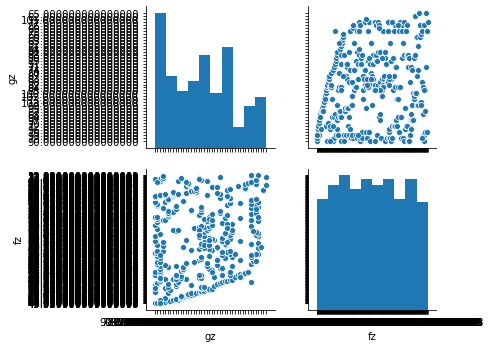

In [120]:
import seaborn as sns
#sns.sedt()
newdf = pd.concat([df.gz, df.fz], axis=1)
print(newdf)
#sns.pairplot(newdf)
